In [4]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '1'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting CUDA visible devices to [1]


In [5]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import numpyro as npr
import numpyro.distributions as dist
from numpyro.distributions import Distribution
import numpyro.distributions.transforms as nprb
import blackjax


import sys

from bamojax.base import Model
from bamojax.samplers import mcmc_sampler
from bamojax.inference import SMCInference


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Numpyro version:    ', npr.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
Jax version:         0.7.2
BlackJax version:    1.2.5
Numpyro version:     0.19.0
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


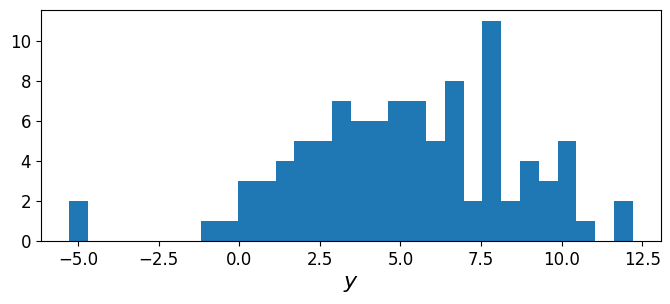

In [6]:
def guk_lml(y, sd, mu0, tau):
    # See https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    y_bar = jnp.mean(y)
    n = len(y)
    return jnp.log(sd) - n/2*jnp.log(2*jnp.pi*sd**2) - 1/2*jnp.log(n*tau**2 + sd**2) - jnp.sum(y**2) / (2*sd**2) - mu0 / (2*tau**2) + (tau**2 * n**2 * y_bar**2 / sd**2 + sd**2*mu0**2 / tau**2 + 2*n*y_bar*mu0) / (2*(n*tau**2 + sd**2))
    
#
def exact_posterior(y, sd, mu0, sd0) -> Distribution:
    """For this simple model, the exact posterior is available (given a Gaussian prior on the mean), which allows us to compare the approximate SMC result with a ground truth.
    
    """
    n = len(y)
    sd_post = 1.0 / (1/sd0**2 + n  / sd**2)
    mu_post = sd_post*(mu0 / sd0**2 + jnp.sum(y) / sd**2)
    return dist.Normal(loc=mu_post, scale=jnp.sqrt(sd_post))

#
# Generate some data

key = jrnd.PRNGKey(5678)
key, key_data, key_inference = jrnd.split(key, 3)

true_mean = 5.0
true_sd = 3.0

n = 100

y = dist.Normal(loc=true_mean, scale=true_sd).sample(key=key_data, sample_shape=(n, ))

plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.hist(y, bins=30)
ax.set_xlabel(r'$y$');

In [7]:
mu0 = 0.0
sd0 = 2.0

gukmodel = Model('Gaussian with unknown mean')
unknown_mean = gukmodel.add_node('mu', distribution=dist.Normal(loc=mu0, scale=sd0))
observations = gukmodel.add_node('y', distribution=dist.Normal, observations=y, parents=dict(loc=unknown_mean, scale=true_sd))

Run SMC and store intermediate output as well.

In [8]:
%%time 
num_particles = 100_000
num_mcmc_steps = 1_000
num_chains = 1

stepsize = 0.01

mcmc_params = dict(sigma=stepsize*jnp.eye(gukmodel.get_model_size()))
rmh = mcmc_sampler(gukmodel, mcmc_kernel=blackjax.normal_random_walk, mcmc_parameters=mcmc_params)

engine = SMCInference(model=gukmodel, num_chains=num_chains, mcmc_kernel=rmh, num_mutations=num_mcmc_steps, num_particles=num_particles, return_trace=True, return_diagnostics=False)
result = engine.run(key_inference)

n_iter = result['n_iter']
lml = result['lml']

exact_lml = guk_lml(mu0=mu0, tau=sd0, sd=true_sd, y=y)
print(f'Log marginal likelihood exact: {exact_lml:0.4f}')
print(f'Log marginal likelihood SMC estimate ({num_particles} particles): {lml:0.4f}')
print(f'Number of SMC cycles: {n_iter}')

Log marginal likelihood exact: -267.9110
Log marginal likelihood SMC estimate (100000 particles): -267.9314
Number of SMC cycles: 18
CPU times: user 30.1 s, sys: 1.11 s, total: 31.2 s
Wall time: 30.7 s


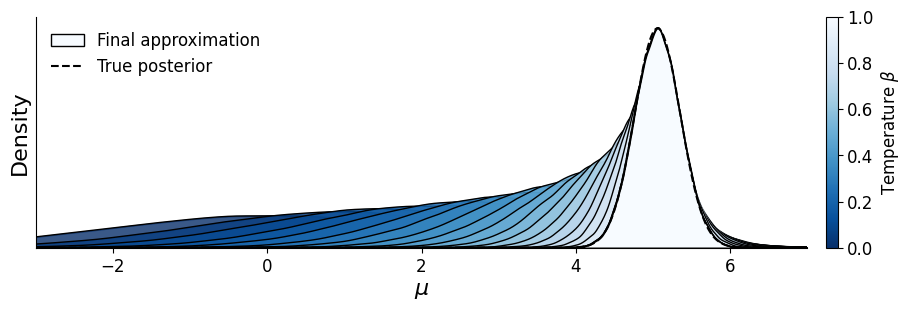

In [10]:
from jax.scipy.stats import gaussian_kde
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_particles(ax, pdf, color, zorder=1.0, alpha=1.0, label=''):
    ax.fill_between(mu_range, pdf(mu_range), jnp.zeros_like(mu_range), alpha=alpha, color=color, zorder=zorder, label=label)
    ax.plot(mu_range, pdf(mu_range), lw=1, color='k', zorder=zorder)

#

xlim = [-3, 7]
mu_range = jnp.linspace(*xlim, num=1000)

cmap = plt.get_cmap('Blues_r')
norm = Normalize(vmin=0, vmax=1.0)

plt.figure(figsize=(12, 3))
ax = plt.gca()
for i in range(n_iter):
    pdf = gaussian_kde(result['trace'].particles['mu'][i, :])
    plot_particles(ax, pdf, cmap(norm(i/n_iter)), zorder=i, alpha=0.8)
    
pdf = gaussian_kde(result['final_state'].particles['mu'].flatten())
plot_particles(ax, pdf, cmap(norm(1.0)), zorder=999, label='Final approximation')

posterior = exact_posterior(y=y, sd=true_sd, mu0=mu0, sd0=sd0)
pdf_post = jnp.exp(posterior.log_prob(mu_range))
ax.plot(mu_range, pdf_post, ls='--', color='k', zorder=9999, label='True posterior')

ax.set_xlabel(r'$\mu$', fontsize=MEDIUM_SIZE)
ax.set_ylabel(r'Density', fontsize=MEDIUM_SIZE)
ax.set_ylim(bottom=0)
for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_zorder(999999)
ax.set_xlim(*xlim)
ax.set_yticklabels([])
ax.set_yticks([])

handles, labels = ax.get_legend_handles_labels()
handles[0].set_edgecolor('k')
ax.legend(handles, labels, fontsize=SMALL_SIZE, frameon=False)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r'Temperature $\beta$', fontsize=SMALL_SIZE)